In [572]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
import pickle
#pd.set_option('display.max_rows', None)
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer #cant impute categorical so we need columntransformer to encode categorical data but i coulnt do!
#from sklearn.compose import ColumnTransformer

In [546]:
def load_data():
    df_train=pd.read_csv('train_titanic.csv',index_col='PassengerId')
    df_test=pd.read_csv('test.csv',index_col='PassengerId')
    return df_train,df_test

In [547]:
def clean(df):
    df['Cabin']=df['Cabin'].str[0]
    df['Ticket']=df['Ticket'].str.extract('(\d+)')
    df['Sex']=df['Sex'].map({'male':1,'female':0})
    df['Cabin'].loc[df['Cabin']=='T']=df['Cabin'].mode()[0]
    
    return df

def impute(df):
    df['Title']=df['Name'].str.extract(' ([A-Z,a-z]+)\.', expand=False)
    df['Age'].fillna(df.groupby('Title')['Age'].transform('mean'),inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0],inplace=True)
    df['Fare'].fillna(df['Fare'].loc[df['Pclass']==3].mean(),inplace=True)
    
    #impute cabins for passengers who have the same ticket number 
    idx=df.duplicated(subset='Ticket',keep=False)[df.duplicated(subset='Ticket',keep=False)].index.values
    df_same_ticket=pd.DataFrame()
    df_same_ticket=df.iloc[idx-1,:]
    same_ticket=df_same_ticket['Ticket'].unique()
    for ticket in same_ticket:
        if df_same_ticket.loc[df_same_ticket['Ticket']==ticket]['Cabin'].notnull().any():
            df_same_ticket['Cabin'].fillna(df_same_ticket.loc[df_same_ticket['Ticket']==ticket]['Cabin'].mode()[0])
    df['Cabin'].iloc[idx-1]=df_same_ticket['Cabin']
   
     #impute the remaining cabins       
    df['Cabin'].loc[df['Pclass']==1]=df['Cabin'].loc[df['Pclass']==1].fillna('Unk1')
    df['Cabin'].loc[df['Pclass']==2]=df['Cabin'].loc[df['Pclass']==2].fillna('Unk2')
    df['Cabin'].loc[df['Pclass']==3]=df['Cabin'].loc[df['Pclass']==3].fillna('Unk3')
    return df

def preprocess(df_train,df_test=None):
    df_train.drop_duplicates(inplace=True)
    df_train.reset_index(drop=True)
    df=pd.concat([df_train,df_test],axis=0)
    df=df[[ 'Name', 'Sex','Age', 'Pclass','SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked','Survived']]
    df=clean(df)
    df=impute(df)
    df_train=df.iloc[df_train.index-1,:]
    df_test=df.iloc[df_test.index-1,:]
    return df_train,df_test

In [548]:
def create_feature(df_train,df_test=None):
    df=pd.concat([df_train,df_test],axis=0)
    
    #creating a feature for sum of number of family members for each passenger
    df['Group']=df['Parch']+df['SibSp']
    
    #creating a binary feature for title of passengers
    df['Title'].loc[df['Title']=='Ms']='Miss'
    List_ordinary=['Mr','Miss','Mrs']
    for i in List_ordinary:
        df['Title'].loc[df['Title']==i]='Ordinary'
    List_special=['Rev','Dr','Col','Mlle','Major','Lady','Sir','Mme','Don','Capt','Countess','Jonkheer','Dona','Master']
    for i in List_special:
        df['Title'].loc[df['Title']==i]='Special'
    
    #converting the ordinaries who have specials in family to special
    idx=df.duplicated(subset='Ticket',keep=False)[df.duplicated(subset='Ticket',keep=False)].index.values
    df_same_Ticket=pd.DataFrame()
    df_same_Ticket=df.iloc[idx-1,:]
    for i in df_same_Ticket['Ticket'].unique():
        if  (df_same_Ticket['Title'].loc[df_same_Ticket['Ticket']==i]=='Special').any():
            df_same_Ticket['Title'].loc[df_same_Ticket['Ticket']==i]='Special'
    df['Title'].iloc[idx-1]=df_same_Ticket['Title']
    df['Title']=df['Title'].map({'Ordinary':0,'Special':1})
    
    
    #a numerical feature for mean of fare in each class
    df['Mean Fare by Class']=df.groupby('Pclass')['Fare'].transform('mean')
    
    #creating a numerical feature for sum of Titled, high Pclassed and young people  
    df['Titled/High/Young']=0
    for i in range(df.shape[0]):
        if (df['Title'].iloc[i]==1) and (df['Age'].iloc[i]<=df['Age'].mean()) and  (df['Fare'].iloc[i]>df['Fare'].loc[df['Pclass']==1].mean()):
            df['Titled/High/Young'].iloc[i]=3
        else:
            if ( ((df['Title'].iloc[i]==1) or  (df['Age'].iloc[i]<=df['Age'].mean())) and  (df['Fare'].iloc[i]>df['Fare'].loc[df['Pclass']==1].mean()) ) or ( ((df['Title'].iloc[i]=='Special') or (df['Fare'].iloc[i]>df['Fare'].loc[df['Pclass']==1].mean())) and (df['Age'].iloc[i]<=df['Age'].mean()) ) or ( ((df['Age'].iloc[i]<=df['Age'].mean()) or  (df['Fare'].iloc[i]>df['Fare'].loc[df['Pclass']==1].mean())) and (df['Title'].iloc[i]=='Special')  ):
                 df['Titled/High/Young'].iloc[i]=2
            else:
                        
                if (df['Title'].iloc[i]==1) or (df['Age'].iloc[i]<=df['Age'].mean()) or (df['Fare'].iloc[i]>df['Fare'].loc[df['Pclass']==1].mean()):
                    df['Titled/High/Young'].iloc[i]=1
    
    df['Title']=df['Name'].str.extract(' ([A-Z,a-z]+)\.', expand=False)
    df['Title'].loc[df['Title']=='Ms']='Miss'
    df['Title'].loc[df['Title']=='Dona']='Don'
    for i in List_ordinary:
        df['Title'].loc[df['Title']==i]='Ordinary'
    List_Special_family=['Mlle','Lady','Sir','Mme','Jonkheer']
    List_Special_position=['Rev','Dr','Col','Major','Don','Capt','Countess','Master']
    for i in List_Special_family:
        df['Title'].loc[df['Title']==i]='Special_family'
    for i in List_Special_position:
        df['Title'].loc[df['Title']==i]='Special_position'
    
    df.drop(['Name','Ticket','SibSp','Parch'],axis=1,inplace=True) 
    df_train=df.iloc[df_train.index-1,:]
    df_test=df.iloc[df_test.index-1,:]
    
    return df_train, df_test

In [549]:
def Scaler(cols_to_scale,X_train=None,X_test=None):
    
    X=pd.concat([X_train,X_test],axis=0)
    
    for col in cols_to_scale:
        X[col]=(X[col]-X[col].mean())/X[col].std()
    X_train=X.iloc[X_train.index-1,:]
    X_test=X.iloc[X_test.index-1,:]
    return X_train,X_test

In [579]:
def dummies(cols_to_dummy,X_train=None,X_test=None):
    X=pd.concat([X_train,X_test],axis=0)
    X[cols_to_dummy]=X[cols_to_dummy].astype('object')
    X_dummy=pd.get_dummies(X[cols_to_dummy],drop_first=True)
    X.drop(cols_to_dummy,axis=1,inplace=True)
    X=X.join(X_dummy)
    X_train=X.iloc[X_train.index-1,:]
    X_test=X.iloc[X_test.index-1,:]
    return X_train,X_test
   

In [580]:
with open('dummies','wb') as file:
    pickle.dump(dummies,file)

In [581]:
with open('Scaler','wb') as file:
    pickle.dump(Scaler,file)

In [551]:
def apply_pca(X_train,X_test):
    X=pd.concat([X_train,X_test],axis=0)
    pca=PCA()
    X_pca=pca.fit_transform(X)
    #plot_variance(pca)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [552]:
df_train,df_test=load_data()

In [553]:
df_train,df_test=preprocess(df_train,df_test)

In [554]:
df_train,df_test=create_feature(df_train,df_test)

In [555]:
X_train=df_train
Y_train=X_train.pop('Survived')
X_test=df_test.drop(['Survived'],axis=1)


In [556]:
#encoder_pclass=LabelEncoder()
#encoder_cabin=LabelEncoder()
#encoder_embarked=LabelEncoder()
#encoder_title=LabelEncoder()
#inputs['Cabin']=encoder_cabin.fit_transform(inputs['Cabin'])
#inputs['Pclass']=encoder_pclass.fit_transform(inputs['Pclass'])
#inputs['Embarked']=encoder_embarked.fit_transform(inputs['Embarked'])
#inputs['Title']=encoder_title.fit_transform(inputs['Title'])


In [557]:
X_train

,Sex,Age,Pclass,Fare,Cabin,Embarked,Title,Group,Mean Fare by Class,Titled/High/Young
PassengerId,,,,,,,,,,
1,1,22.000000,3,7.2500,Unk3,S,Ordinary,1,13.302889,1
2,0,38.000000,1,71.2833,C,C,Ordinary,1,87.508992,0
3,0,26.000000,3,7.9250,Unk3,S,Ordinary,0,13.302889,1
4,0,35.000000,1,53.1000,C,S,Ordinary,1,87.508992,0
5,1,35.000000,3,8.0500,Unk3,S,Ordinary,0,13.302889,0
...,...,...,...,...,...,...,...,...,...,...
887,1,27.000000,2,13.0000,Unk2,S,Special_position,0,21.179196,1
888,0,19.000000,1,30.0000,B,S,Ordinary,0,87.508992,1
889,0,21.774238,3,23.4500,Unk3,S,Ordinary,3,13.302889,1


In [558]:
cols_to_scale=['Fare','Age','Group','Titled/High/Young','Mean Fare by Class']
X_train,x_test=Scaler(cols_to_scale,X_train, X_test)

In [559]:
cols_to_dummy=['Embarked','Cabin','Title','Pclass']
X_train,X_test=dummies(cols_to_dummy,X_train,X_test)

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

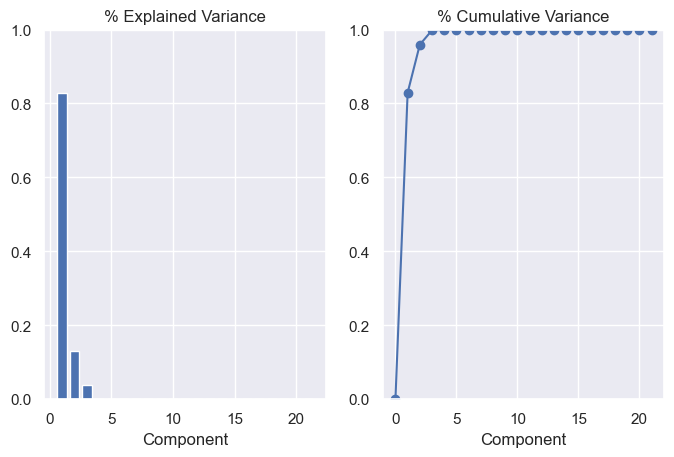

In [560]:
pca, X_pca, loadings=apply_pca(X_train,X_test)
plot_variance(pca)

In [561]:
mi_scores=mutual_info_classif(X_pca.iloc[X_train.index,:],Y_train)
mi_scores

array([0.0199164 , 0.00193299, 0.00172411, 0.        , 0.01966293,
       0.00401456, 0.01077836, 0.02082461, 0.01364422, 0.00543873,
       0.00428628, 0.        , 0.00051582, 0.00281918, 0.01029082,
       0.        , 0.00373024, 0.00786691, 0.00491747, 0.0128685 ,
       0.02510265])

In [562]:
mi_scores=mutual_info_classif(X_train,Y_train)

pd.DataFrame(X_train.corrwith(Y_train),columns=['Correlation']).join(pd.DataFrame(mi_scores,index=X_train.columns,columns=['mi_score']))


,Correlation,mi_score
Sex,-0.543351,0.164661
Age,-0.087092,0.058017
Fare,0.257307,0.122197
Group,0.016639,0.038795
Mean Fare by Class,0.302585,0.081796
Titled/High/Young,0.168721,0.053694
Embarked_Q,0.003650,0.000000
Embarked_S,-0.149683,0.000000
Cabin_B,0.175095,0.018064
Cabin_C,0.110226,0.005224


# Logistic Regression

In [325]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#model_reg=LogisticRegression()
model_reg=GridSearchCV(LogisticRegression(solver='liblinear',multi_class='auto'),{'C':[1,5,10]})
model_reg.fit(X_train,Y_train)
pd.DataFrame(model_reg.cv_results_)
#dir(model_reg)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004527,0.004473,0.001793,0.001495,1,{'C': 1},0.821229,0.820225,0.780899,0.820225,0.837079,0.815931,0.018652,1
1,0.004713,0.004888,0.001807,0.003152,5,{'C': 5},0.821229,0.814607,0.780899,0.820225,0.831461,0.813684,0.017271,2
2,0.007874,0.006997,0.000000,0.000000,10,{'C': 10},0.821229,0.814607,0.786517,0.814607,0.831461,0.813684,0.014918,2


In [326]:
print('Best Score for 5Fold Cross Validation For LR: ',model_reg.best_score_) #best score is mean of scores for 5 fold. it is test score 

Best Score for 5Fold Cross Validation For LR:  0.8159312033142928


In [327]:
model_reg.best_params_

{'C': 1}

In [328]:
from sklearn import metrics
print('Accuracy for Logistic Regression:\n\n',model_reg.score(X_train,Y_train))#this is train score without fold the whole dataset assumed to be train

Accuracy for Logistic Regression:

 0.819304152637486


In [329]:
from sklearn.metrics import confusion_matrix, classification_report
print('Classification report for oversampling by logistic regression:\n\n',classification_report(Y_train,model_reg.predict(X_train)))

Classification report for oversampling by logistic regression:

               precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       549
         1.0       0.79      0.73      0.76       342

    accuracy                           0.82       891
   macro avg       0.81      0.80      0.81       891
weighted avg       0.82      0.82      0.82       891



In [330]:
from sklearn.metrics import precision_recall_curve, f1_score,auc
precision,recall,threshold=precision_recall_curve(Y_train,model_reg.predict_proba(X_train)[:,1])
fscore=(2*precision*recall)/(precision+recall)
ix=np.argmax(fscore)
print('Best Threshold=%.3f\nBest Fscore=%.3f'%(threshold[ix],fscore[ix]))
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(Y_train,model_reg.predict_proba(X_train)[:,1])
print('AUC for logistic Regression=%.3f'%auc(fpr, tpr))

Best Threshold=0.346
Best Fscore=0.769
AUC for logistic Regression=0.875


# SVM

In [331]:
from sklearn import svm
model_svm =GridSearchCV(svm.SVC(gamma='auto',probability=True),{'C':[1,10,20],'kernel':['linear','rbf']})
model_svm.fit(X_train,Y_train)
print('Best Score for 5Fold Cross Validation For SVM: ',model_svm.best_score_) #best score is mean of scores for 5 fold. it is test score
print('Accuracy for SVM: ',model_svm.score(X_train,Y_train))#this is train score without fold the whole dataset assumed to be train
print('Classification report for svm:\n\n',classification_report(Y_train,model_svm.predict(X_train)))

Best Score for 5Fold Cross Validation For SVM:  0.8271671583704727
Accuracy for SVM:  0.8540965207631874
Classification report for svm:

               precision    recall  f1-score   support

         0.0       0.86      0.91      0.89       549
         1.0       0.85      0.76      0.80       342

    accuracy                           0.85       891
   macro avg       0.85      0.84      0.84       891
weighted avg       0.85      0.85      0.85       891



In [332]:
predicted_proba=model_svm.predict_proba(X_train)
precision,recall,threshold=precision_recall_curve(Y_train,predicted_proba[:,1])
fscore=(2*precision*recall)/(precision+recall)
ix=np.argmax(fscore)
print('Best Threshold=%.3f\nBest Fscore=%.3f'%(threshold[ix],fscore[ix]))
fpr, tpr, thresholds = roc_curve(Y_train,predicted_proba[:,1])
print('AUC for SVM=%.3f'%auc(fpr, tpr))

Best Threshold=0.228
Best Fscore=0.812
AUC for SVM=0.899


# Random Forest

In [333]:
from sklearn.ensemble import RandomForestClassifier
model_rf =GridSearchCV( RandomForestClassifier(),{'n_estimators':[1,5,10]})
model_rf.fit(X_train,Y_train)
print('Best Score for 5Fold Cross Validation For RF: ',model_rf.best_score_) #best score is mean of scores for 5 fold. it is test score
print('Accuracy for RF: ',model_rf.score(X_train,Y_train))#this is train score without fold the whole dataset assumed to be train
print('Classification report for RF:\n\n',classification_report(Y_train,model_rf.predict(X_train)))

Best Score for 5Fold Cross Validation For RF:  0.8148578243675851
Accuracy for RF:  0.9753086419753086
Classification report for RF:

               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       549
         1.0       0.97      0.96      0.97       342

    accuracy                           0.98       891
   macro avg       0.97      0.97      0.97       891
weighted avg       0.98      0.98      0.98       891



In [334]:
predicted_proba=model_rf.predict_proba(X_train)
precision,recall,threshold=precision_recall_curve(Y_train,predicted_proba[:,1])
fscore=(2*precision*recall)/(precision+recall)
ix=np.argmax(fscore)
print('Best Threshold=%.3f\nBest Fscore=%.3f'%(threshold[ix],fscore[ix]))
fpr, tpr, thresholds = roc_curve(Y_train,predicted_proba[:,1])
print('AUC for RF=%.3f'%auc(fpr, tpr))

Best Threshold=0.500
Best Fscore=0.970
AUC for RF=0.996


#   GradientBoosting Classifier

In [93]:
from sklearn.ensemble import GradientBoostingClassifier
parameters={
    'learning_rate':[0.05,0.1,0.2],
    'min_samples_split':np.linspace(0.1,.5,12),
    'min_samples_leaf':np.linspace(0.1,.5,12),
    'max_depth':[3,5,8],
    'max_features':['sqrt'],
    'criterion':['mse'],
    'subsample':[0.5,.81],
    'n_estimators':[10,100]
}
model_gb =GridSearchCV(GradientBoostingClassifier(),parameters)
model_gb.fit(X_train,Y_train)


GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'criterion': ['mse'],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 8], 'max_features': ['sqrt'],
                         'min_samples_leaf': array([0.1       , 0.13636364, 0.17272727, 0.20909091, 0.24545455,
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
       0.46363636, 0.5       ]),
                         'min_samples_split': array([0.1       , 0.13636364, 0.17272727, 0.20909091, 0.24545455,
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
       0.46363636, 0.5       ]),
                         'n_estimators': [10, 100], 'subsample': [0.5, 0.81]})

 all the params are:
 parameters={
    'learning_rate':[0.01,0.025,0.05,0.075,0.1,0.15,0.2],
    'min_samples_split':np.linspace(0.1,.5,12),
    'min_samples_leaf':np.linspace(0.1,.5,12),
    'max_depth':[3,5,8],
    'max_features':['log2','sqrt'],
    'criterion':['fridman_mse','squared_error','mse'],
    'subsample':[0.5,0.618,.8,.85,.9,.95,1],
    #'n_estimators':[10,50,100]

In [94]:
print('Best Score for 5Fold Cross Validation For GB: ',model_gb.best_score_) #best score is mean of scores for 5 fold. it is test score
print('Accuracy for GB: ',model_gb.score(X_train,Y_train))#this is train score without fold the whole dataset assumed to be train
print('Classification report for GB:\n\n',classification_report(Y_train,model_gb.predict(X_train)))

Best Score for 5Fold Cross Validation For GB:  0.8215931203314293
Accuracy for GB:  0.8507295173961841
Classification report for GB:

               precision    recall  f1-score   support

         0.0       0.84      0.94      0.89       549
         1.0       0.88      0.71      0.79       342

    accuracy                           0.85       891
   macro avg       0.86      0.82      0.84       891
weighted avg       0.85      0.85      0.85       891



In [95]:
predicted_proba=model_gb.predict_proba(X_train)
precision,recall,threshold=precision_recall_curve(Y_train,predicted_proba[:,1])
fscore=(2*precision*recall)/(precision+recall)
ix=np.argmax(fscore)
print('Best Threshold=%.3f\nBest Fscore=%.3f'%(threshold[ix],fscore[ix]))
fpr, tpr, thresholds = roc_curve(Y_train,predicted_proba[:,1])
print('AUC for RF=%.3f'%auc(fpr, tpr))

Best Threshold=0.429
Best Fscore=0.798
AUC for RF=0.903


## AdaBoost ensemble 

In [335]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
model_adaboost=AdaBoostClassifier()

scores=cross_val_score(model_adaboost,X_train, Y_train,cv=5)
model_adaboost.fit(X_train,Y_train)
scores.mean()

0.8148578243675851

In [1046]:
print('Classification report for AdaBoost:\n\n',classification_report(Y_train,model_adaboost.predict(X_train)))

Classification report for AdaBoost:

               precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       549
         1.0       0.80      0.78      0.79       342

    accuracy                           0.84       891
   macro avg       0.83      0.83      0.83       891
weighted avg       0.84      0.84      0.84       891



## XGBoost 

In [413]:
from xgboost import XGBClassifier
params={'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]}
model_xgboost =GridSearchCV(XGBClassifier(),params)
model_xgboost.fit(X_train,Y_train)
print('Best Score for 5Fold Cross Validation For xgboost: ',model_xgboost.best_score_) #best score is mean of scores for 5 fold. it is test score
print('Accuracy for xgboost: ',model_xgboost.score(X_train,Y_train))#this is train score without fold the whole dataset assumed to be train

[18:54:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:19] WARNING:

[18:54:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:23] WARNING:

[18:54:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:27] WARNING:

[18:54:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:31] WARNING:

[18:54:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:35] WARNING:

[18:54:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:39] WARNING:

[18:54:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:43] WARNING:

[18:54:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:46] WARNING:

[18:54:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:50] WARNING:

[18:54:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:54] WARNING:

[18:54:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:58] WARNING:

[18:55:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:02] WARNING:

[18:55:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:05] WARNING:

[18:55:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:09] WARNING:

[18:55:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:13] WARNING:

[18:55:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:17] WARNING:

[18:55:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:21] WARNING:

[18:55:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:25] WARNING:

[18:55:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:29] WARNING:

[18:55:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:32] WARNING:

[18:55:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:37] WARNING:

[18:55:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:41] WARNING:

[18:55:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:44] WARNING:

[18:55:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:48] WARNING:

[18:55:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:52] WARNING:

[18:55:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:56] WARNING:

[18:56:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:00] WARNING:

[18:56:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:04] WARNING:

[18:56:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:08] WARNING:

[18:56:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:12] WARNING:

[18:56:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:16] WARNING:

[18:56:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:20] WARNING:

[18:56:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:24] WARNING:

[18:56:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:27] WARNING:

[18:56:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:31] WARNING:

[18:56:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:36] WARNING:

[18:56:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:40] WARNING:

[18:56:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:43] WARNING:

[18:56:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:47] WARNING:

[18:56:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:51] WARNING:

[18:56:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:55] WARNING:

[18:56:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:59] WARNING:

[18:57:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:03] WARNING:

[18:57:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:06] WARNING:

[18:57:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:11] WARNING:

[18:57:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:14] WARNING:

[18:57:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:19] WARNING:

[18:57:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:23] WARNING:

[18:57:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:26] WARNING:

[18:57:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:30] WARNING:

[18:57:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:34] WARNING:

[18:57:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:39] WARNING:

[18:57:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:43] WARNING:

[18:57:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:47] WARNING:

[18:57:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:50] WARNING:

[18:57:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:54] WARNING:

[18:57:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:59] WARNING:

[18:58:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:03] WARNING:

[18:58:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:06] WARNING:

[18:58:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:10] WARNING:

[18:58:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:14] WARNING:

[18:58:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:18] WARNING:

[18:58:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:22] WARNING:

[18:58:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:26] WARNING:

[18:58:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:30] WARNING:

[18:59:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:19] WARNING:

[18:59:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:40] WARNING:

[18:59:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:50] WARNING:

[18:59:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:58] WARNING:

[19:00:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:05] WARNING:

[19:00:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:12] WARNING:

[19:00:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:19] WARNING:

[19:00:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:27] WARNING:

[19:00:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:32] WARNING:

[19:00:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:36] WARNING:

[19:00:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:40] WARNING:

[19:00:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:45] WARNING:

[19:00:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:51] WARNING:

In [484]:
print('Classification report for XGBoost:\n\n',classification_report(Y_train,model_xgboost.predict(X_train)))

Classification report for XGBoost:

               precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       549
         1.0       0.92      0.83      0.87       342

    accuracy                           0.90       891
   macro avg       0.91      0.89      0.90       891
weighted avg       0.91      0.90      0.90       891



In [485]:
predicted_proba=model_xgboost.predict_proba(X_train)
precision,recall,threshold=precision_recall_curve(Y_train,predicted_proba[:,1])
fscore=(2*precision*recall)/(precision+recall)
ix=np.argmax(fscore)
print('Best Threshold=%.3f\nBest Fscore=%.3f'%(threshold[ix],fscore[ix]))
fpr, tpr, thresholds = roc_curve(Y_train,predicted_proba[:,1])
print('AUC for RF=%.3f'%auc(fpr, tpr))

Best Threshold=0.449
Best Fscore=0.876
AUC for RF=0.954


In [563]:
best_params=model_xgboost.best_params_

AttributeError: 'XGBClassifier' object has no attribute 'best_params_'

In [564]:
model_xgboost=XGBClassifier(**best_params)
model_xgboost.fit(X_train,Y_train)

[20:20:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [573]:
with open('model_xgboost_titanic','wb') as file:
    pickle.dump(model_xgboost,file)

# Deep Learning


In [44]:
import tensorflow  as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import initializers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#  ANN with KFold and validation _data (manual)

In [1115]:
BUFFER_SIZE=50
#BATCH_SIZE=40  #model.fit(inputs_preprocessed.iloc[train_index,:],targets.iloc[train_index],validation_data=(inputs_preprocessed.iloc[valid_index,:],targets.iloc[valid_index]),batch_size=BATCH_SIZE, epochs=max_epochs,callbacks=[early_stopping] , verbose =2)
input_size = 8
output_size = 2
max_epochs=100
# Use same hidden layer size for both hidden layers. Not a necessity.
hidden_layer_size =65
#train_dataset = tf.data.Dataset.from_tensor_slices((inputs_preprocessed,targets))
#train_dataset=train_dataset.shuffle(BUFFER_SIZE)
#train_dataset=train_dataset.batch(BATCH_SIZE)
#test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
initializer_sigtan=initializers.GlorotUniform()
initializer_relu=initializers.HeUniform()
kfold = StratifiedKFold(n_splits=3, shuffle=True,random_state=42)
for train_index, valid_index in kfold.split(X_train,Y_train):
    model = tf.keras.Sequential([
    # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
    # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
    tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu), 
    tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu),
    tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid',kernel_initializer=initializer_sigtan),
        # the final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
    
    history=model.fit(X_train.iloc[train_index,:],Y_train.iloc[train_index],validation_data=(X_train.iloc[valid_index,:],Y_train.iloc[valid_index]),epochs=max_epochs,callbacks=[early_stopping] , verbose =2)

Epoch 1/100
19/19 - 1s - loss: 0.6008 - accuracy: 0.6835 - val_loss: 0.5507 - val_accuracy: 0.7643 - 789ms/epoch - 42ms/step
Epoch 2/100
19/19 - 0s - loss: 0.5343 - accuracy: 0.7374 - val_loss: 0.5055 - val_accuracy: 0.7710 - 90ms/epoch - 5ms/step
Epoch 3/100
19/19 - 0s - loss: 0.4854 - accuracy: 0.7929 - val_loss: 0.4601 - val_accuracy: 0.8283 - 92ms/epoch - 5ms/step
Epoch 4/100
19/19 - 0s - loss: 0.4518 - accuracy: 0.8249 - val_loss: 0.4393 - val_accuracy: 0.8182 - 93ms/epoch - 5ms/step
Epoch 5/100
19/19 - 0s - loss: 0.4267 - accuracy: 0.8232 - val_loss: 0.4255 - val_accuracy: 0.8249 - 86ms/epoch - 5ms/step
Epoch 6/100
19/19 - 0s - loss: 0.4160 - accuracy: 0.8283 - val_loss: 0.4256 - val_accuracy: 0.8081 - 100ms/epoch - 5ms/step
Epoch 7/100
19/19 - 0s - loss: 0.4034 - accuracy: 0.8182 - val_loss: 0.4142 - val_accuracy: 0.8283 - 98ms/epoch - 5ms/step
Epoch 8/100
19/19 - 0s - loss: 0.3989 - accuracy: 0.8266 - val_loss: 0.4092 - val_accuracy: 0.8249 - 101ms/epoch - 5ms/step
Epoch 9/100


# ANN for cross_val_score with Dropout (without validation)

In [533]:
#BUFFER_SIZE=50
#BATCH_SIZE=40  #model.fit(inputs_preprocessed.iloc[train_index,:],targets.iloc[train_index],validation_data=(inputs_preprocessed.iloc[valid_index,:],targets.iloc[valid_index]),batch_size=BATCH_SIZE, epochs=max_epochs,callbacks=[early_stopping] , verbose =2)
input_size =X_train.shape[1]
output_size = 2
max_epochs=25
hidden_layer_size =90
initializer_sigtan=initializers.GlorotUniform()
initializer_relu=initializers.HeUniform()
def create_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu), 
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu),
    #tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu),
    tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid',kernel_initializer=initializer_sigtan), 
    
    tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid',kernel_initializer=initializer_sigtan),
    tf.keras.layers.Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
model_CV = KerasClassifier(build_fn=create_model,epochs=max_epochs,verbose=2)
results=cross_val_score(model_CV,X_train,Y_train,cv=kfold)

Epoch 1/25
23/23 - 1s - loss: 0.6628 - accuracy: 0.6180 - 517ms/epoch - 22ms/step
Epoch 2/25
23/23 - 0s - loss: 0.6090 - accuracy: 0.6643 - 64ms/epoch - 3ms/step
Epoch 3/25
23/23 - 0s - loss: 0.5342 - accuracy: 0.7626 - 53ms/epoch - 2ms/step
Epoch 4/25
23/23 - 0s - loss: 0.4859 - accuracy: 0.7949 - 53ms/epoch - 2ms/step
Epoch 5/25
23/23 - 0s - loss: 0.4607 - accuracy: 0.8034 - 52ms/epoch - 2ms/step
Epoch 6/25
23/23 - 0s - loss: 0.4350 - accuracy: 0.8230 - 52ms/epoch - 2ms/step
Epoch 7/25
23/23 - 0s - loss: 0.4255 - accuracy: 0.8272 - 57ms/epoch - 2ms/step
Epoch 8/25
23/23 - 0s - loss: 0.4201 - accuracy: 0.8287 - 52ms/epoch - 2ms/step
Epoch 9/25
23/23 - 0s - loss: 0.4236 - accuracy: 0.8287 - 56ms/epoch - 2ms/step
Epoch 10/25
23/23 - 0s - loss: 0.4009 - accuracy: 0.8427 - 54ms/epoch - 2ms/step
Epoch 11/25
23/23 - 0s - loss: 0.4079 - accuracy: 0.8301 - 57ms/epoch - 2ms/step
Epoch 12/25
23/23 - 0s - loss: 0.3895 - accuracy: 0.8399 - 57ms/epoch - 2ms/step
Epoch 13/25
23/23 - 0s - loss: 0.39

Epoch 25/25
23/23 - 0s - loss: 0.3550 - accuracy: 0.8541 - 53ms/epoch - 2ms/step
6/6 - 0s - loss: 0.4063 - accuracy: 0.8258 - 203ms/epoch - 34ms/step
Epoch 1/25
23/23 - 1s - loss: 0.6644 - accuracy: 0.6438 - 554ms/epoch - 24ms/step
Epoch 2/25
23/23 - 0s - loss: 0.6129 - accuracy: 0.6606 - 63ms/epoch - 3ms/step
Epoch 3/25
23/23 - 0s - loss: 0.5373 - accuracy: 0.7419 - 51ms/epoch - 2ms/step
Epoch 4/25
23/23 - 0s - loss: 0.5046 - accuracy: 0.7686 - 50ms/epoch - 2ms/step
Epoch 5/25
23/23 - 0s - loss: 0.4619 - accuracy: 0.8121 - 51ms/epoch - 2ms/step
Epoch 6/25
23/23 - 0s - loss: 0.4403 - accuracy: 0.8163 - 50ms/epoch - 2ms/step
Epoch 7/25
23/23 - 0s - loss: 0.4266 - accuracy: 0.8135 - 50ms/epoch - 2ms/step
Epoch 8/25
23/23 - 0s - loss: 0.4148 - accuracy: 0.8303 - 51ms/epoch - 2ms/step
Epoch 9/25
23/23 - 0s - loss: 0.4076 - accuracy: 0.8275 - 51ms/epoch - 2ms/step
Epoch 10/25
23/23 - 0s - loss: 0.3964 - accuracy: 0.8233 - 49ms/epoch - 2ms/step
Epoch 11/25
23/23 - 0s - loss: 0.4017 - accurac

In [507]:
results #test acc for each split

array([0.83798885, 0.85393256, 0.83707863, 0.8202247 , 0.81460673])

In [508]:
results.mean() #this is important because our dataset is small and after deciding on the model structure and hyperparameters its better to retrain the model with whole the data so we wont choose the best split as our model

0.8327662944793701

# ANN for train_test_spilit

In [539]:
output_size = 2
max_epochs=25
hidden_layer_size =90
initializer_sigtan=initializers.GlorotUniform()
initializer_relu=initializers.HeUniform()
train_x,test_x,train_y,test_y=train_test_split(X_train,Y_train,shuffle=True,test_size=0.1)
model = tf.keras.Sequential([
tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu), 
tf.keras.layers.Dropout(0.2),    
tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu),
#tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu),
tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid',kernel_initializer=initializer_sigtan), 
tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid',kernel_initializer=initializer_sigtan),    
tf.keras.layers.Dense(output_size, activation='softmax')
    ])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_x,train_y,epochs=max_epochs, verbose =2)

Epoch 1/25
26/26 - 1s - loss: 0.6332 - accuracy: 0.6255 - 570ms/epoch - 22ms/step
Epoch 2/25
26/26 - 0s - loss: 0.5498 - accuracy: 0.7366 - 62ms/epoch - 2ms/step
Epoch 3/25
26/26 - 0s - loss: 0.4948 - accuracy: 0.7815 - 54ms/epoch - 2ms/step
Epoch 4/25
26/26 - 0s - loss: 0.4549 - accuracy: 0.8090 - 66ms/epoch - 3ms/step
Epoch 5/25
26/26 - 0s - loss: 0.4364 - accuracy: 0.8240 - 62ms/epoch - 2ms/step
Epoch 6/25
26/26 - 0s - loss: 0.4258 - accuracy: 0.8277 - 61ms/epoch - 2ms/step
Epoch 7/25
26/26 - 0s - loss: 0.4256 - accuracy: 0.8127 - 55ms/epoch - 2ms/step
Epoch 8/25
26/26 - 0s - loss: 0.4151 - accuracy: 0.8277 - 66ms/epoch - 3ms/step
Epoch 9/25
26/26 - 0s - loss: 0.3980 - accuracy: 0.8402 - 64ms/epoch - 2ms/step
Epoch 10/25
26/26 - 0s - loss: 0.3978 - accuracy: 0.8340 - 62ms/epoch - 2ms/step
Epoch 11/25
26/26 - 0s - loss: 0.3962 - accuracy: 0.8414 - 62ms/epoch - 2ms/step
Epoch 12/25
26/26 - 0s - loss: 0.3967 - accuracy: 0.8365 - 54ms/epoch - 2ms/step
Epoch 13/25
26/26 - 0s - loss: 0.42

In [540]:
model.evaluate(test_x,test_y)

3/3 [==============================] - 0s 3ms/step - loss: 0.4335 - accuracy: 0.8222


[0.43345749378204346, 0.8222222328186035]

In [541]:
predicted_proba=model.predict(test_x)
precision,recall,threshold=precision_recall_curve(test_y,predicted_proba[:,1])
fscore=(2*precision*recall)/(precision+recall)
ix=np.argmax(fscore)
print('Best Threshold=%.3f\nBest Fscore=%.3f'%(threshold[ix],fscore[ix]))

3/3 [==============================] - 0s 3ms/step
Best Threshold=0.815
Best Fscore=0.764


# ANN for whole X_train with best chosen params

In [509]:
output_size = 2
max_epochs=25
hidden_layer_size =90
initializer_sigtan=initializers.GlorotUniform()
initializer_relu=initializers.HeUniform()
model_NN= tf.keras.Sequential([
tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu), 
tf.keras.layers.Dropout(0.2),    
tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu),
    #tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_initializer=initializer_relu),
tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid',kernel_initializer=initializer_sigtan), 
    tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid',kernel_initializer=initializer_sigtan), 
tf.keras.layers.Dense(output_size, activation='softmax')
    ])
model_NN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_NN.fit(X_train,Y_train, epochs=max_epochs, verbose =2)

Epoch 1/25
28/28 - 2s - loss: 0.6351 - accuracy: 0.6352 - 2s/epoch - 79ms/step
Epoch 2/25
28/28 - 0s - loss: 0.5539 - accuracy: 0.7295 - 62ms/epoch - 2ms/step
Epoch 3/25
28/28 - 0s - loss: 0.4976 - accuracy: 0.7868 - 67ms/epoch - 2ms/step
Epoch 4/25
28/28 - 0s - loss: 0.4463 - accuracy: 0.8159 - 66ms/epoch - 2ms/step
Epoch 5/25
28/28 - 0s - loss: 0.4251 - accuracy: 0.8260 - 67ms/epoch - 2ms/step
Epoch 6/25
28/28 - 0s - loss: 0.4122 - accuracy: 0.8249 - 66ms/epoch - 2ms/step
Epoch 7/25
28/28 - 0s - loss: 0.4057 - accuracy: 0.8305 - 67ms/epoch - 2ms/step
Epoch 8/25
28/28 - 0s - loss: 0.4077 - accuracy: 0.8339 - 66ms/epoch - 2ms/step
Epoch 9/25
28/28 - 0s - loss: 0.4141 - accuracy: 0.8272 - 70ms/epoch - 3ms/step
Epoch 10/25
28/28 - 0s - loss: 0.3981 - accuracy: 0.8373 - 68ms/epoch - 2ms/step
Epoch 11/25
28/28 - 0s - loss: 0.3835 - accuracy: 0.8328 - 66ms/epoch - 2ms/step
Epoch 12/25
28/28 - 0s - loss: 0.3851 - accuracy: 0.8328 - 65ms/epoch - 2ms/step
Epoch 13/25
28/28 - 0s - loss: 0.3971 

## Test

In [565]:
predicted_proba=model_xgboost.predict_proba(X_test)
results=np.where(predicted_proba[:,1]>=.45,1,0)
results_titanic=pd.DataFrame(results,columns=['Survived'])
results_titanic['PassengerId']=X_test.index
results_titanic['Survived']=results_titanic['Survived'].astype('int')
results_titanic=results_titanic[["PassengerId",'Survived']]

In [566]:
pd.DataFrame(results_titanic).to_csv('results_titanic.csv',index=False)

<bound method XGBClassifier.__init__ of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)>